In [1]:
# Incorporate point-correlation
def correlation_fun(x,input_dim,Rad):
    point_corr=0
    for i in range(input_dim):
        for j in range(input_dim):
            point_corr_temp1=tf.multiply(x[0][i,j],x[0][i,tf.mod(j+Rad,input_dim)])
            point_corr=tf.add(point_corr_temp1,point_corr)
    
    for i in range(input_dim):
        for j in range(input_dim):           
            point_corr_temp2=tf.multiply(x[0][i,j],x[0][tf.mod(i+Rad,input_dim),j])
            point_corr=tf.add(point_corr_temp2,point_corr)
    return (point_corr+2*input_dim**2)/4./1

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import scipy.io as sio
# from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data



# mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
images = np.array(sio.loadmat('WB_test64_GAN_sm2.mat')['WB_sm'],dtype='float32')
images[images==0]=-1

mb_size = 1
z_dim = 8
X_dim = images.shape[1]
width = 32
hight = 32
h_dim = 8*8
input_dim = 32
Rad = input_dim/2

conv1_features=64*2
conv2_features=32*2
conv3_features=1
c = 0

num_channels_1=1
num_channels_2=64*2
num_channels_3=32*2
lr = 1e-3


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(32, 32), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


# =============================== Q(z|X) ======================================

# X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])
x_input_shape = (mb_size, width, hight, num_channels_1)
X = tf.placeholder(tf.float32, shape=x_input_shape)

# conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features],
#                                                stddev=0.1, dtype=tf.float32))
# conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X):
#     conv1 = tf.nn.conv2d(X, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
#     h1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
#     h1 = tf.reshape(h1,[mb_size,X_dim])
    
    h = tf.nn.relu(tf.matmul(tf.reshape(X,[mb_size,X_dim]), Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar

def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps


# =============================== P(X|z) ======================================

P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
# P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

deconv1_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, num_channels_1],
                                               stddev=0.1, dtype=tf.float32))
deconv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

deconv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv2_features,num_channels_2],
                                               stddev=0.1, dtype=tf.float32))
deconv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

deconv3_weight = tf.Variable(tf.truncated_normal([4, 4, conv3_features, num_channels_3],
                                               stddev=0.1, dtype=tf.float32))
deconv3_bias = tf.Variable(tf.zeros([conv3_features], dtype=tf.float32))



def P(z):
    h1 = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    h2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h1,[mb_size, width/4, hight/4, 1]), 
                                                  deconv1_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/2, hight/2, conv1_features]),deconv1_bias))
#     h2 = build_unpool(h2_conv, [1, 2, 2, 1])
    
    h3 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h2,[mb_size, width/2, hight/2, conv1_features]), 
                                                  deconv2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, hight/1, conv2_features]),deconv2_bias))
    
    h4 = (tf.add(tf.nn.conv2d_transpose(tf.reshape(h3,[mb_size, width/1, hight/1, conv2_features]), 
                                                  deconv3_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, hight/1, conv3_features]),deconv3_bias))
    
    prob = tf.nn.tanh(h4)
    return prob


# =============================== TRAINING ====================================

z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
prob = P(z_sample)

# Sampling from random z
X_samples = P(z)

# point correlation loss
PC_ori=correlation_fun(X, input_dim=input_dim, Rad=Rad)
PC_rec=correlation_fun(prob, input_dim=input_dim, Rad=Rad)
PC_ran_temp=[]
for i in range(10):
    PC_ran_temp = tf.concat([PC_ran_temp, correlation_fun(X_samples, input_dim=input_dim, Rad=Rad)],0)
# PC_ran=correlation_fun(X_samples,input_dim=input_dim, Rad=Rad)
PC_ran = tf.reduce_mean(PC_ran_temp)
PC_loss1=tf.abs(PC_ori-PC_rec)
PC_loss2=tf.abs(PC_ori-PC_ran)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.square((tf.reshape(prob,[mb_size, X_dim])-tf.reshape(X,[mb_size, X_dim]))), 1)/4
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss + PC_loss1 + PC_loss2)

solver = tf.train.AdamOptimizer().minimize(vae_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0
PC_ori=[]
saver = tf.train.Saver()

for it in range(400000):
    X_mb = images[(it*mb_size)%100:(it*mb_size)%100+mb_size]
#     PC_ori = tf.reduce_mean(tf.concat([PC_ori, PC_ori_temp],0))
    
#     print((it*10)%100,(it*10)%100+mb_size)
    _, loss, recon_E, kl_E, PC_E1, PC_E2 = sess.run([solver, vae_loss, recon_loss, kl_loss, PC_loss1, PC_loss2], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim)})

    if it % 250 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        print('PC_E1:{}'.format(PC_E1))
        print('PC_E2:{}'.format(PC_E2))
        
        print()

        samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
save_path = saver.save(sess, "/tmp/model.ckpt")

Iter: 0
Loss: 528.180053711
recon_E:[ 292.87158203]
kl_E:[ 7.93682003]
PC_E1:[ 97.42175293]
PC_E2:[ 129.94989014]
()
Iter: 250
Loss: 326.533630371
recon_E:[ 232.74420166]
kl_E:[ 2.50510764]
PC_E1:[ 46.15649414]
PC_E2:[ 45.12780762]
()
Iter: 500
Loss: 416.686462402
recon_E:[ 210.07380676]
kl_E:[ 13.06885338]
PC_E1:[ 83.06365967]
PC_E2:[ 110.48016357]
()
Iter: 750
Loss: 271.394958496
recon_E:[ 224.26631165]
kl_E:[ 8.93906021]
PC_E1:[ 15.75958252]
PC_E2:[ 22.42999268]
()
Iter: 1000
Loss: 362.450744629
recon_E:[ 209.76104736]
kl_E:[ 20.13592529]
PC_E1:[ 22.19866943]
PC_E2:[ 110.35510254]
()
Iter: 1250
Loss: 322.140380859
recon_E:[ 233.70440674]
kl_E:[ 1.02460098]
PC_E1:[ 48.07409668]
PC_E2:[ 39.33728027]
()
Iter: 1500
Loss: 340.228149414
recon_E:[ 214.86135864]
kl_E:[ 4.20627403]
PC_E1:[ 46.45062256]
PC_E2:[ 74.7098999]
()
Iter: 1750
Loss: 327.496337891
recon_E:[ 235.20962524]
kl_E:[ 0.05434176]
PC_E1:[ 48.83587646]
PC_E2:[ 43.39648438]
()
Iter: 2000
Loss: 425.574707031
recon_E:[ 208.73011

KeyboardInterrupt: 

In [7]:
for it in range(400000):
    X_mb = images[(it*10)%100:(it*10)%100+mb_size]
#     PC_ori = tf.reduce_mean(tf.concat([PC_ori, PC_ori_temp],0))
    
#     print((it*10)%100,(it*10)%100+mb_size)
    _, loss, recon_E, kl_E, PC_E1, PC_E2 = sess.run([solver, vae_loss, recon_loss, kl_loss, PC_loss1, PC_loss2], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim)})

    if it % 250 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        print('PC_E1:{}'.format(PC_E1))
        print('PC_E2:{}'.format(PC_E2))
        
        print()

        samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
save_path = saver.save(sess, "/tmp/model.ckpt")

Iter: 0
Loss: 221.832183838
recon_E:[ 74.71923828]
kl_E:[ 40.43948364]
PC_E1:[ 7.48901367]
PC_E2:[ 99.18444824]
()
Iter: 250
Loss: 270.951873779
recon_E:[ 78.35773468]
kl_E:[ 35.49422073]
PC_E1:[ 41.56652832]
PC_E2:[ 115.53338623]
()
Iter: 500
Loss: 224.925704956
recon_E:[ 54.57610321]
kl_E:[ 42.03747177]
PC_E1:[ 5.68597412]
PC_E2:[ 122.62615967]
()
Iter: 750
Loss: 216.196731567
recon_E:[ 54.85420609]
kl_E:[ 35.20415497]
PC_E1:[ 1.07653809]
PC_E2:[ 125.06182861]
()
Iter: 1000
Loss: 237.90196228
recon_E:[ 53.29034042]
kl_E:[ 39.86106873]
PC_E1:[ 25.65087891]
PC_E2:[ 119.09967041]
()
Iter: 1250
Loss: 201.056274414
recon_E:[ 49.65494156]
kl_E:[ 34.00064087]
PC_E1:[ 14.75256348]
PC_E2:[ 102.64813232]
()
Iter: 1500
Loss: 210.60559082
recon_E:[ 50.86982346]
kl_E:[ 36.71312714]
PC_E1:[ 4.18652344]
PC_E2:[ 118.83612061]
()
Iter: 1750
Loss: 204.333984375
recon_E:[ 41.76177597]
kl_E:[ 28.832407]
PC_E1:[ 15.33770752]
PC_E2:[ 118.40209961]
()
Iter: 2000
Loss: 208.627502441
recon_E:[ 48.22374725]
k

KeyboardInterrupt: 

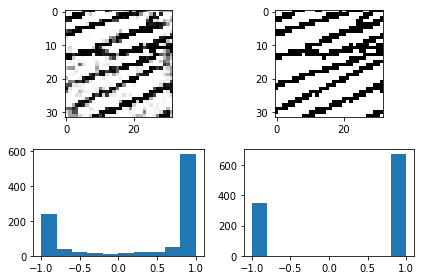

In [3]:
z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, hight, num_channels_1)})
%matplotlib inline
sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:1]})
# plot_new(sample_temp)
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.imshow(sample_temp.reshape(32,32),'gray')

ax2 = fig.add_subplot(222)
ax2.imshow(X_mb.reshape(32,32),'gray')

ax3 = fig.add_subplot(223)
ax3.hist(sample_temp.reshape(-1))

ax4 = fig.add_subplot(224)
ax4.hist(X_mb.reshape(-1))


plt.tight_layout()
fig = plt.gcf()

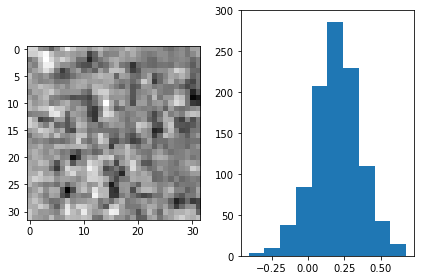

In [4]:
samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})
fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.imshow(samples.reshape(32,32),'gray')

ax2 = fig.add_subplot(122)
ax2.hist(samples.reshape(-1))
plt.tight_layout()